In [19]:
import os

import pandas as pd
import numpy as np
import json
import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import plot_importance

from sklearn.feature_extraction.text import CountVectorizer

from sklearn.metrics import accuracy_score
from sklearn import metrics
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [20]:
train_data = pd.read_csv('C:/Users/DSSAL/Downloads/XGB_mobilehealth/revision_data/traindata_2020_afterCovid.csv')

In [21]:
train_data = train_data.dropna()

In [22]:
reviews = list(train_data['clean_review'])
sentiments = list(train_data['sentiment'])

In [23]:
vectorizer = CountVectorizer(analyzer = "word", max_features = 5000) 

x_train = vectorizer.fit_transform(reviews)
y_train = np.array(sentiments)

In [24]:
x_train

<19462x5000 sparse matrix of type '<class 'numpy.int64'>'
	with 219930 stored elements in Compressed Sparse Row format>

In [25]:
# 하이퍼 파라미터 튜닝 및 XGboost 훈련
from sklearn.model_selection import GridSearchCV

xgb = XGBClassifier(random_state=82, n_estimators = 100, learning_rate=0.2, max_depth=4)

xgb_param_grid = {
    'n_estimators' : [200, 600, 1000], #200, 400, 600
    'learning_rate' : [0.05, 0.1, 0.2], #, 0.05, 0.1, 0.15, 0.2
    'max_depth' : [4, 6, 8] #4, 6, 8, 12
}

xgb = GridSearchCV(xgb, param_grid = xgb_param_grid, scoring = 'accuracy', n_jobs=-1, verbose=3, cv=5)
#n_jobs = XGBoost를 실행하는데 사용되는 병렬 스레드 수

# 단어 묶음을 벡터화한 데이터와 정답 데이터를 가지고 학습을 시작한다.
bst = xgb.fit(x_train, y_train, verbose=3)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


C:\Users\DSSAL\Anaconda3\lib\site-packages\cupy\_environment.py:214: UserWarning: CUDA path could not be detected. Set CUDA_PATH environment variable if CuPy fails to load.
  'CUDA path could not be detected.'
C:\Users\DSSAL\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[01:20:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [26]:
print("Accuracy: %f" %  xgb.score(x_train, y_train))

Accuracy: 0.951392


In [27]:
#검증데이터셋 성능 평가
test_data = pd.read_csv('C:/Users/DSSAL/Downloads/XGB_mobilehealth/revision_data/testdata_2021_afterCovid.csv')
test_data = test_data.dropna()

test_reviews = list(test_data['clean_review'])

In [28]:
test_data_features = vectorizer.transform(test_reviews)
test_input = test_data_features

realAnswer = list(test_data['sentiment'])
test_label = np.array(realAnswer)

In [29]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

y_pred = xgb.predict(test_input)
predictions = [round(value) for value in y_pred]

accuracy_score(test_label, predictions)

C:\Users\DSSAL\Anaconda3\lib\site-packages\cupy\_environment.py:214: UserWarning: CUDA path could not be detected. Set CUDA_PATH environment variable if CuPy fails to load.
  'CUDA path could not be detected.'


0.8916444336648072

Text(0.5, 257.44, 'Predicted label')

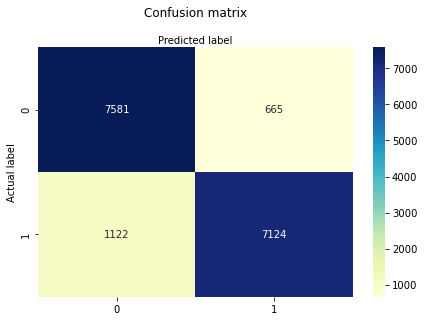

In [30]:
cnf_matrix = metrics.confusion_matrix(test_label, predictions)

class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [31]:
print("Accuracy:",metrics.accuracy_score(test_label, predictions))
print("Precision:",metrics.precision_score(test_label, predictions))
print("Recall:",metrics.recall_score(test_label, predictions))

Accuracy: 0.8916444336648072
Precision: 0.9146231865451278
Recall: 0.863934028619937


In [45]:
import joblib

# 모델 저장
joblib.dump(xgb, 'C:/Users/DSSAL/Downloads/XGB_mobilehealth/xgb_bow_with_gridsearch_afterCovid.pkl')

# 모델 불러오기
xgb_model = joblib.load('C:/Users/DSSAL/Downloads/XGB_mobilehealth/xgb_bow_with_gridsearch_afterCovid.pkl')

In [46]:
xgb_model

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     enable_categorical=False, gamma=None,
                                     gpu_id=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=0.2, max_delta_step=None,
                                     max_depth=4, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=82, reg_alpha=None,
                                     reg_lambda=None, scale_pos_weight=None,

In [47]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

y_pred = xgb_model.predict(test_input)
predictions = [value for value in y_pred]

accuracy_score(test_label, predictions)

C:\Users\DSSAL\Anaconda3\lib\site-packages\cupy\_environment.py:214: UserWarning: CUDA path could not be detected. Set CUDA_PATH environment variable if CuPy fails to load.
  'CUDA path could not be detected.'


0.8916444336648072

In [48]:
from sklearn.metrics import classification_report

report = classification_report(test_label, y_pred, target_names=['class low', 'class high'], output_dict=True)
df = pd.DataFrame(report).transpose()

df

,precision,recall,f1-score,support
class low,0.871079,0.919355,0.894566,8246.000000
class high,0.914623,0.863934,0.888556,8246.000000
accuracy,0.891644,0.891644,0.891644,0.891644
macro avg,0.892851,0.891644,0.891561,16492.000000
weighted avg,0.892851,0.891644,0.891561,16492.000000


In [49]:
xgb.best_params_

{'learning_rate': 0.2, 'max_depth': 6, 'n_estimators': 1000}